In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.support_functions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
dat = scrap_covid_data()

# START scraping
### Requesting url nr 1
### Requesting url nr 2
# END scraping


In [80]:
data = cut_down(dat)

In [8]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [9]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

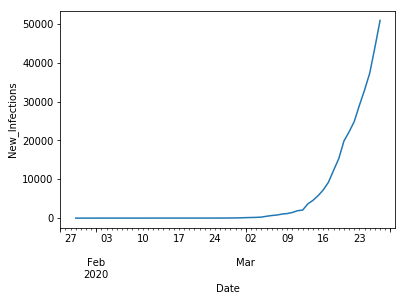

In [10]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('New_Infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

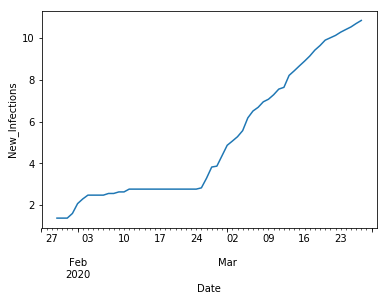

In [11]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected'].iloc[1:]).plot()
ax.set_ylabel('New_Infections')

### Analyse the stationarity of the time series 

In [12]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.10970490165175578
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Indicates AR 1 Process


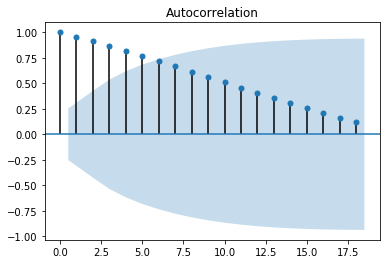

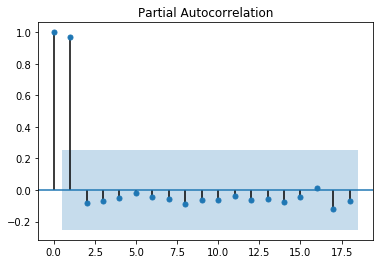

In [13]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])
print('Indicates AR 1 Process')

### Fit ARIMA model with Auto ARIMA 

In [14]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0); AIC=-40.548, BIC=-36.393, Fit time=0.244 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-54.374, BIC=-48.141, Fit time=0.265 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-50.943, BIC=-44.711, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-55.307, BIC=-46.997, Fit time=0.114 seconds
Total fit time: 0.722 seconds
-55.307486903043184


### Forecasting 

In [15]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
print(future_forecast)

[38148.01504439 44174.00072826 51207.15177066]


In [16]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

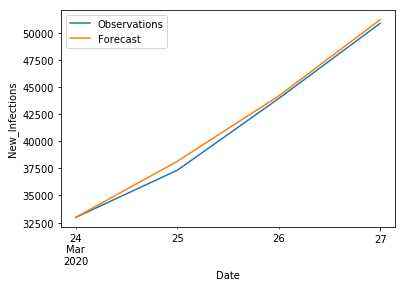

In [17]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

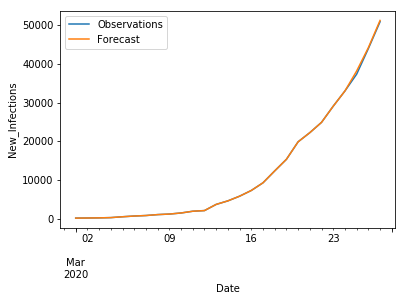

In [18]:
fig, ax = plt.subplots()
test_series.loc['2020-03-01':].plot()
forecast_series.loc['2020-03-01':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

# Model growth rate of Covid 19 in China 
## Fit polynom and extract parameters

In [152]:
#Get the Data 
CH = country_filter(data, Country='China')
state_list = CH['Province/State'].drop_duplicates()

### Example: Fit polynom to data in Zhejiang 

In [153]:
y = np.array(CH.loc[CH['Province/State']=='Zhejiang','Infected'].transform(lambda x: x*(100/x.max())))
x = np.array(range(0,len(y)),dtype=float)
#params,_ = fit(logistic,x,y)
params = np.polyfit(x,y, deg=3)
p = np.poly1d(params)
print(params)

[ 1.43295886e-03 -1.91113372e-01  8.18625454e+00 -1.43167368e+01]


Text(0,0.5,'Number of Infections in %')

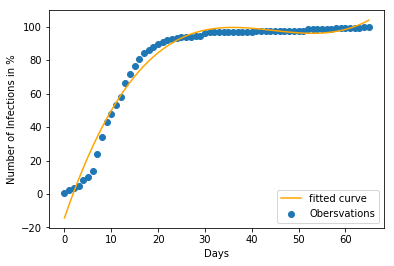

In [154]:
fig, axes = plt.subplots()
plt.scatter(x,y)
plt.plot(x,p(x),color='orange')
#plt.plot(x,logistic(x,params[0],params[1],params[2],params[3],params[4]),color='orange')
axes.legend(['fitted curve','Obersvations'])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Infections in %')

### Fit the polynom for each state & extract parameters

In [155]:
params = list()
missing_states = list()
for state in state_list:
    y = CH.loc[CH['Province/State']==state,'Infected'].transform(lambda x: x*(100/x.max()))
    x = np.array(range(0,len(y)),dtype=float)
    try:
        new_params = np.polyfit(x,y, deg=3)
        params.append(new_params)
    except:
        print('Couldnt fit:',state)
        missing_states.append(state)        
fit_state = state_list.loc[~np.isin(state_list,missing_states)]
target = pd.DataFrame(params, columns=['x3', 'x2', 'x1', 'c',], index = fit_state)    
        

### Read in features

In [266]:
import pandas as pd
import os 

os.chdir('/Users/matthiasboeker/Desktop/Covid_19_Forecast/Data')
data_files = []
for file in os.listdir():
    if file.endswith('.csv'):
        data_files.append(file)
        #data_list = data_list
features=[]
for i in range(0,len(data_files)):        
    d = pd.read_csv(data_files[i], sep=',', skiprows=3, encoding= 'unicode_escape')
    d.index = d.loc[:,'Region']
    d = d.loc[:,'2018']
    d = d.rename(data_files[i][:-4])
    cut = 1
    if len(d)>32:
        cut = (len(d)-32)+1
    d= d.iloc[:-cut]
    features.append(d)
    
feature_space = pd.DataFrame(features).T

In [267]:
print('Targets Index',len(target.index))
print('Features Index',len(feature_space.index))
target = target.drop(target.index[~np.isin(target.index,feature_space.index)].values)
feature_space = feature_space.drop('Passenger_National_Railroad',axis=1)

Targets Index 31
Features Index 31


In [268]:
feature_space['Urban_Ratio'] = feature_space['Urban_Res']/feature_space['Rural_Res']
feature_space = feature_space.drop(['Urban_Res','Rural_Res'],axis=1)
feature_space['Students'] = feature_space['Students_high']+feature_space['Students_primary']+feature_space['Students_Secondary']
feature_space = feature_space.drop(['Students_high','Students_primary','Students_Secondary'],axis=1)
feature_space['Perc_Gen_Hospitals'] = feature_space['Number_general_hospitals']/feature_space['Number_health_inst']

### Analyse the correlation of the feature space

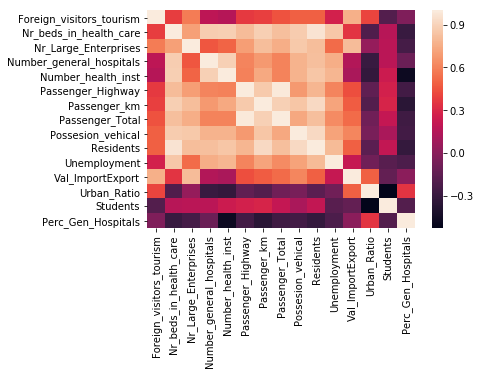

In [269]:
import seaborn as sn
corr = feature_space.corr()
sn.heatmap(corr, annot=False)

plt.show()

In [270]:
feature_space = feature_space.drop(['Number_general_hospitals','Number_health_inst','Nr_beds_in_health_care',
                                   'Nr_Large_Enterprises','Possesion_vehical',
                                   'Passenger_km','Passenger_Total','Passenger_Highway','Foreign_visitors_tourism',
                                   'Perc_Gen_Hospitals','Residents','Val_ImportExport','Students'],axis=1)

In [271]:
feature_space = feature_space.sort_index()
target = target.sort_index()

### Get weather data

In [221]:
from datetime import date, timedelta
from weatherbit.api import Api
import json
api_key = '90c0fe3847f2481a801b44297e55857b'
api = Api(api_key)
api.set_granularity('daily')
today = date.today()
start = today-timedelta(7)
#temp_data = pd.DataFrame(columns=['State', 'Date','temp','percip'])
temp_data = list()
state_list = state_list.append(pd.Series(['Germany']))
for state in state_list:
    #print(state)
    for i in range(0,7):
        lon = CH.loc[CH['Province/State']==state,'Long'][0]
        lat = CH.loc[CH['Province/State']==state,'Lat'][0]
        interval_b = start + timedelta(i)
        interval_e = interval_b + timedelta(1)
        #print('Begin:',interval_b.strftime("%Y-%m-%d"))
        #print('End:',interval_e.strftime("%Y-%m-%d"))
        history = api.get_history(lat=lat,lon=lon, start_date= interval_b.strftime("%Y-%m-%d"),end_date=interval_e.strftime("%Y-%m-%d"))
        lis = history.get_series(['precip','temp'])
        dic ={"State": state,'Date':interval_b.strftime("%Y-%m-%d"),'temp':lis[0]['temp'],'precip':lis[0]['precip']}
        temp_data.append(dic)

HTTPError: 429 Client Error:  for url: https://api.weatherbit.io/v2.0/history/daily?key=90c0fe3847f2481a801b44297e55857b&lat=37.8099&lon=101.0583&start_date=2020-03-23&end_date=2020-03-24

### Fit first linear regression for socio econ variables

In [272]:
import statsmodels.api as sm
mod = sm.GLS(target['x3'], feature_space)
res = mod.fit()
print(res.summary())

                                 GLS Regression Results                                
Dep. Variable:                     x3   R-squared (uncentered):                   0.607
Model:                            GLS   Adj. R-squared (uncentered):              0.580
Method:                 Least Squares   F-statistic:                              22.42
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                    1.30e-06
Time:                        21:36:42   Log-Likelihood:                          181.25
No. Observations:                  31   AIC:                                     -358.5
Df Residuals:                      29   BIC:                                     -355.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------